In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans

# model validation
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

DATA_PATH = "/content/drive/MyDrive/project/data/"

In [78]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
test = pd.read_csv(f"{DATA_PATH}test.csv")
sub = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

In [79]:
train.head()

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20220601 00     1  20220601 00   18.6      NaN      0.9   42.0     NaN   
1  1_20220601 01     1  20220601 01   18.0      NaN      1.1   45.0     NaN   
2  1_20220601 02     1  20220601 02   17.7      NaN      1.5   45.0     NaN   
3  1_20220601 03     1  20220601 03   16.7      NaN      1.4   48.0     NaN   
4  1_20220601 04     1  20220601 04   18.4      NaN      2.8   43.0     NaN   

   일사(MJ/m2)  전력소비량(kWh)  
0        NaN     1085.28  
1        NaN     1047.36  
2        NaN      974.88  
3        NaN      953.76  
4        NaN      986.40

In [80]:
test.head()

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)
0  1_20220825 00     1  20220825 00   23.5      0.0      2.2     72
1  1_20220825 01     1  20220825 01   23.0      0.0      0.9     72
2  1_20220825 02     1  20220825 02   22.7      0.0      1.5     75
3  1_20220825 03     1  20220825 03   22.1      0.0      1.3     78
4  1_20220825 04     1  20220825 04   21.8      0.0      1.0     77

In [81]:
train.shape , test.shape , sub.shape

((204000, 10), (16800, 7), (16800, 2))

In [82]:
train.columns = ['num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도', '일조', '일사', 'target']
test.columns = ['num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도']

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   num            204000 non-null  int64  
 2   date_time      204000 non-null  object 
 3   기온             204000 non-null  float64
 4   강수량            43931 non-null   float64
 5   풍속             203981 non-null  float64
 6   습도             203991 non-null  float64
 7   일조             128818 non-null  float64
 8   일사             116087 non-null  float64
 9   target         204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [84]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   num            16800 non-null  int64  
 2   date_time      16800 non-null  object 
 3   기온             16800 non-null  float64
 4   강수량            16800 non-null  float64
 5   풍속             16800 non-null  float64
 6   습도             16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


In [85]:
sns.set_style('whitegrid')

In [86]:
eda_df = train.copy()

In [87]:
# adding features related to datetime
eda_df['date_time'] = pd.to_datetime(eda_df['date_time'])
eda_df['hour'] = eda_df['date_time'].dt.hour
eda_df['weekday'] = eda_df['date_time'].dt.weekday
eda_df['date'] = eda_df['date_time'].dt.date
eda_df['day'] = eda_df['date_time'].dt.day
eda_df['month'] = eda_df['date_time'].dt.month
eda_df['weekend'] = eda_df['weekday'].isin([5,6]).astype(int)

In [88]:
eda_df.head()

num_date_time  num           date_time    기온  강수량   풍속    습도  일조  일사  \
0  1_20220601 00    1 2022-06-01 00:00:00  18.6  NaN  0.9  42.0 NaN NaN   
1  1_20220601 01    1 2022-06-01 01:00:00  18.0  NaN  1.1  45.0 NaN NaN   
2  1_20220601 02    1 2022-06-01 02:00:00  17.7  NaN  1.5  45.0 NaN NaN   
3  1_20220601 03    1 2022-06-01 03:00:00  16.7  NaN  1.4  48.0 NaN NaN   
4  1_20220601 04    1 2022-06-01 04:00:00  18.4  NaN  2.8  43.0 NaN NaN   

    target  hour  weekday        date  day  month  weekend  
0  1085.28     0        2  2022-06-01    1      6        0  
1  1047.36     1        2  2022-06-01    1      6        0  
2   974.88     2        2  2022-06-01    1      6        0  
3   953.76     3        2  2022-06-01    1      6        0  
4   986.40     4        2  2022-06-01    1      6        0

<Axes: >

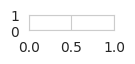

In [89]:
plt.subplot(20, 5, 100)

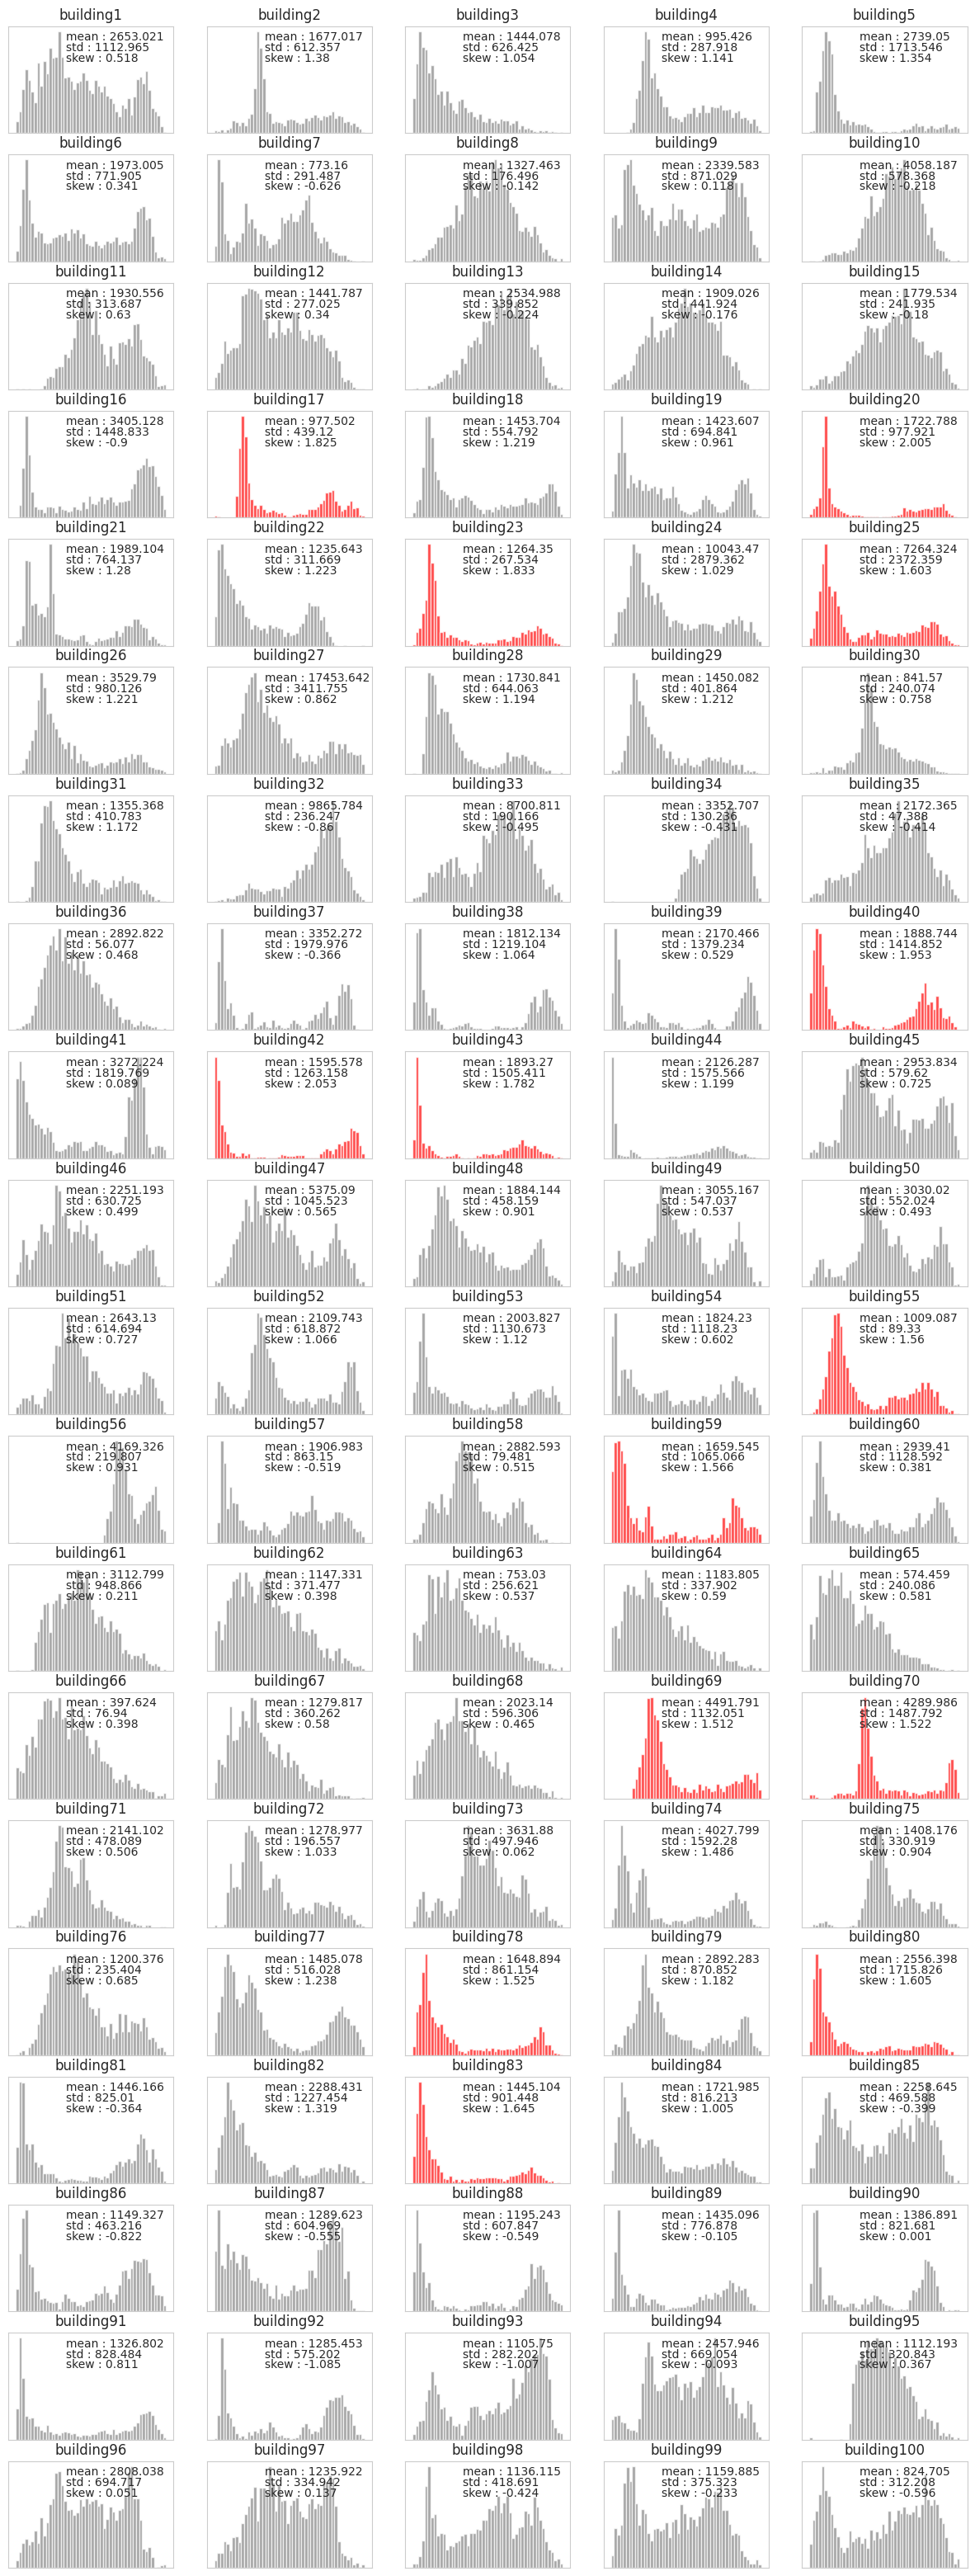

In [90]:
fig = plt.figure(figsize = (15, 40))
for num in range(1,101):
    ax = plt.subplot(20, 5, num)
    energy = eda_df.loc[eda_df.num == num, 'target'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

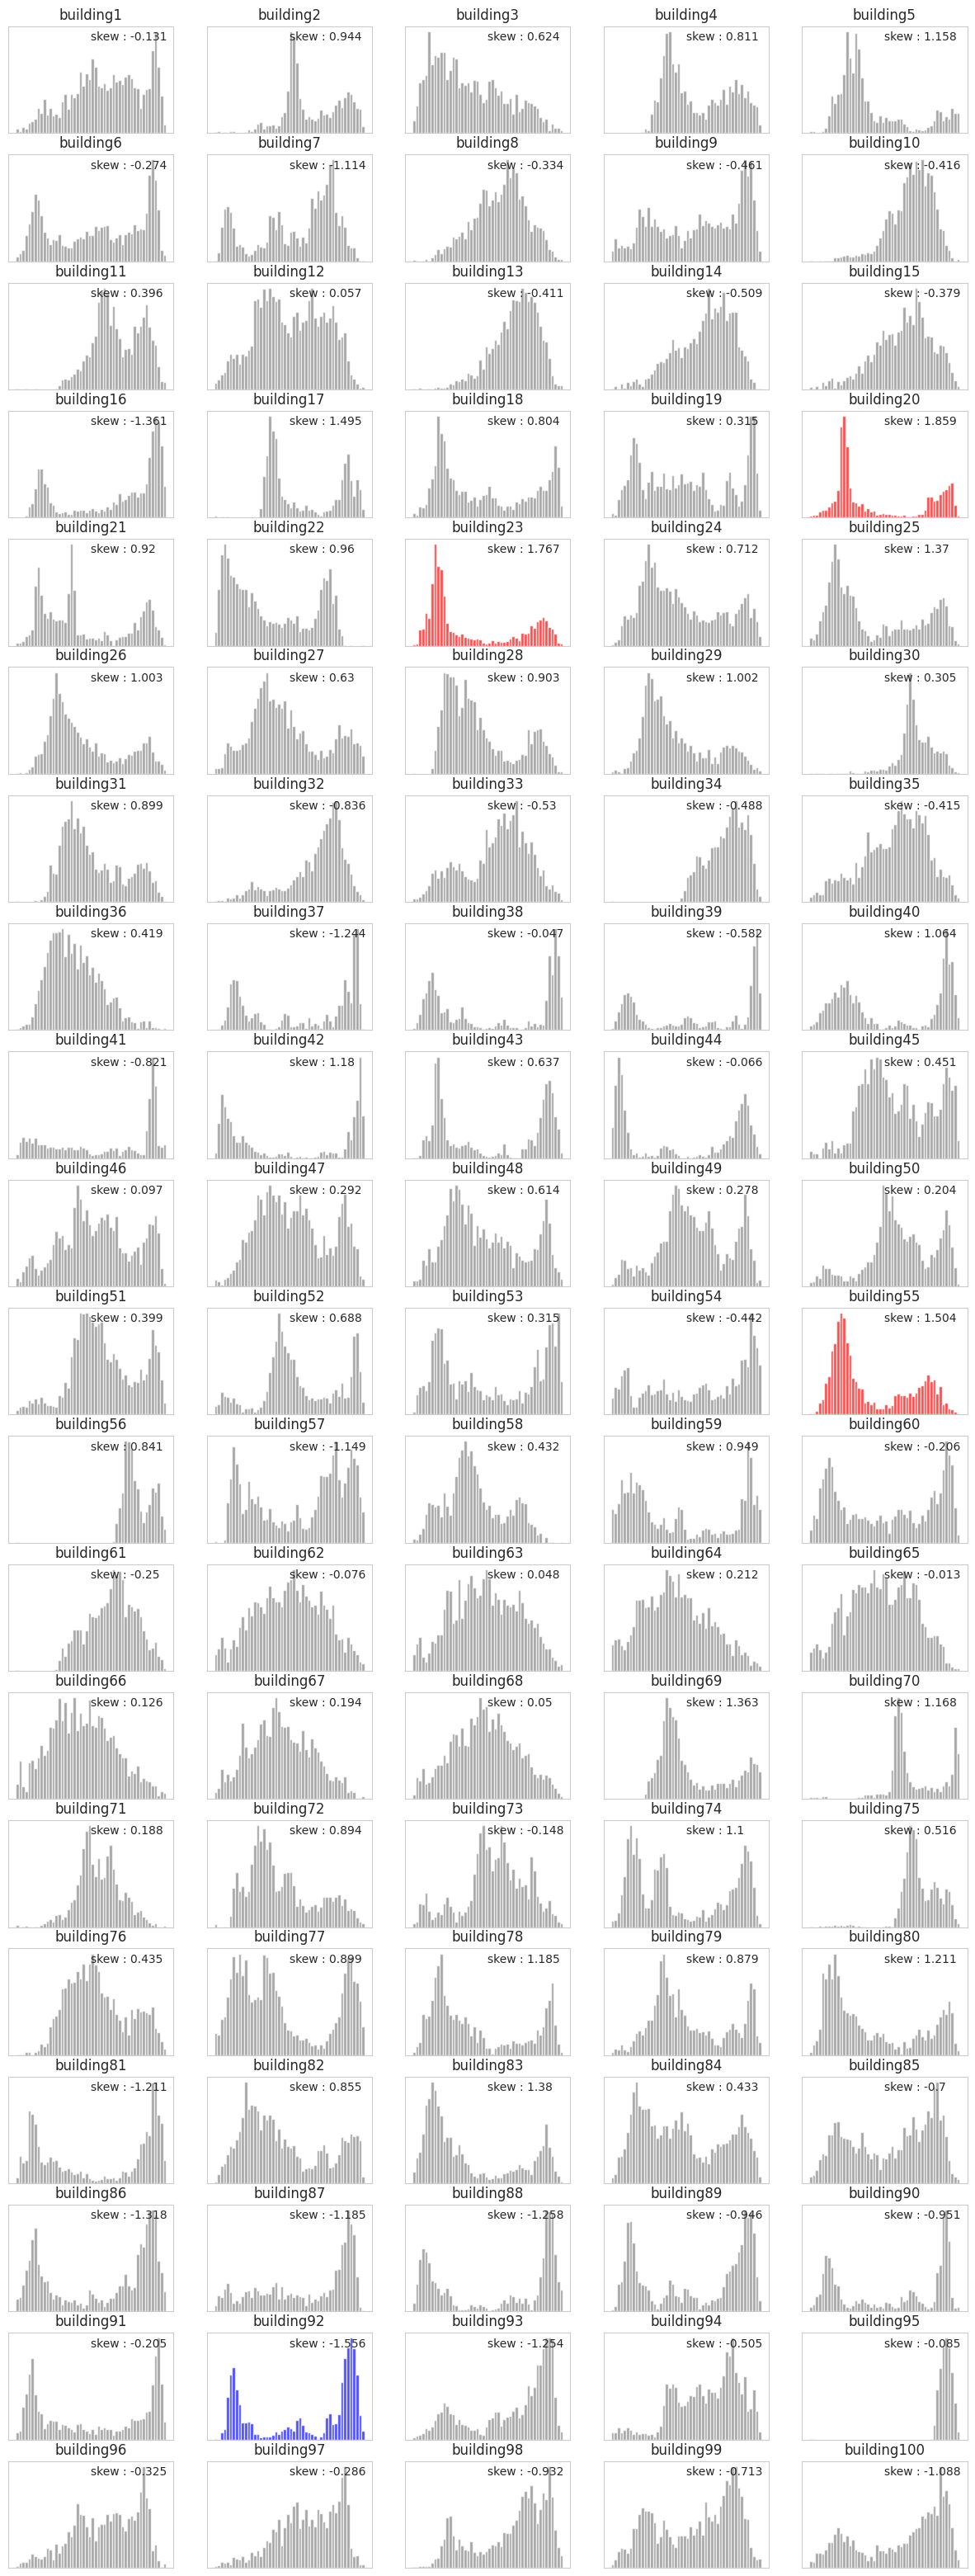

In [91]:
fig = plt.figure(figsize = (15, 40))
for num in range(1,101):
    ax = plt.subplot(20, 5, num)
    energy = np.log(1 + eda_df.loc[eda_df.num == num, 'target'].values)
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

In [92]:
# 로그 변환을 통해 왜도값이 줄어듦을 확인했으니, target을 로그변환한 값으로 학습해야 함
# 추론 시에는 모델 예측값에 역로그 변환(exponential)을 적용해야 함

# 모델의 로그 변환된 예측값
# log_pred = 2.0

# 역 로그 변환 (exponential)
# original_pred = np.exp(log_pred)

In [93]:
eda_df.describe()

num             기온           강수량             풍속  \
count  204000.000000  204000.000000  43931.000000  203981.000000   
mean       50.500000      25.543524      2.040830       2.134031   
std        28.866141       3.779523      5.165218       1.358109   
min         1.000000      10.100000      0.000000       0.000000   
25%        25.750000      23.400000      0.000000       1.200000   
50%        50.500000      25.700000      0.100000       2.000000   
75%        75.250000      28.100000      1.300000       2.800000   
max       100.000000      37.100000     92.200000      13.300000   

                  습도             일조             일사         target  \
count  203991.000000  128818.000000  116087.000000  204000.000000   
mean       78.716295       0.333637       1.063823    2451.036462   
std        15.080108       0.401486       1.001030    2440.648858   
min        13.000000       0.000000       0.000000       0.000000   
25%        69.000000       0.000000       0.200000    1085.760000   
50%        81.000000       0.100000       0.710000    1766.400000   
75%        91.000000       0.700000       1.780000    2970.000000   
max       100.000000       1.000000       3.920000   25488.400000   

                hour        weekday            day          month  \
count  204000.000000  204000.000000  204000.000000  204000.000000   
mean       11.500000       2.988235      14.835294       6.929412   
std         6.922204       1.991127       8.446178       0.793923   
min         0.000000       0.000000       1.000000       6.000000   
25%         5.750000       1.000000       8.000000       6.000000   
50%        11.500000       3.000000      15.000000       7.000000   
75%        17.250000       5.000000      22.000000       8.000000   
max        23.000000       6.000000      31.000000       8.000000   

             weekend  
count  204000.000000  
mean        0.282353  
std         0.450145  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

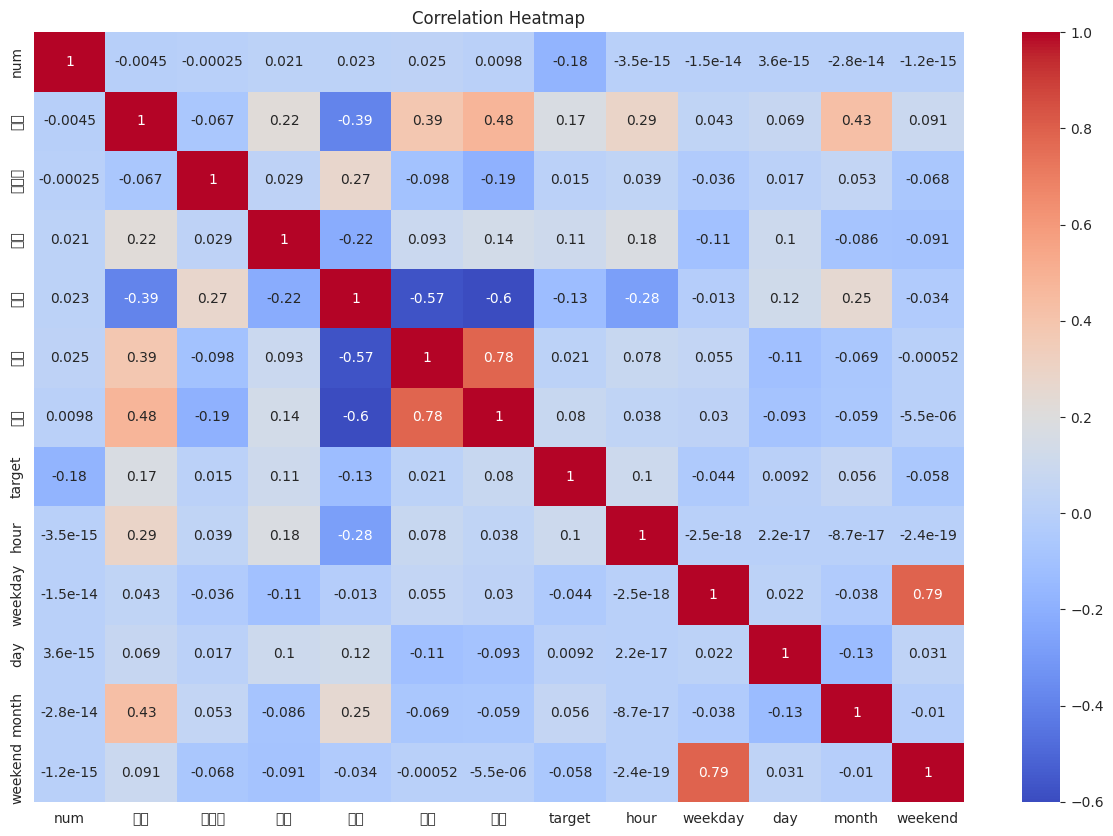

In [94]:
# 상관 관계 행렬
correlation_matrix = eda_df.corr()

# 히트맵을 사용한 상관 관계 시각화
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


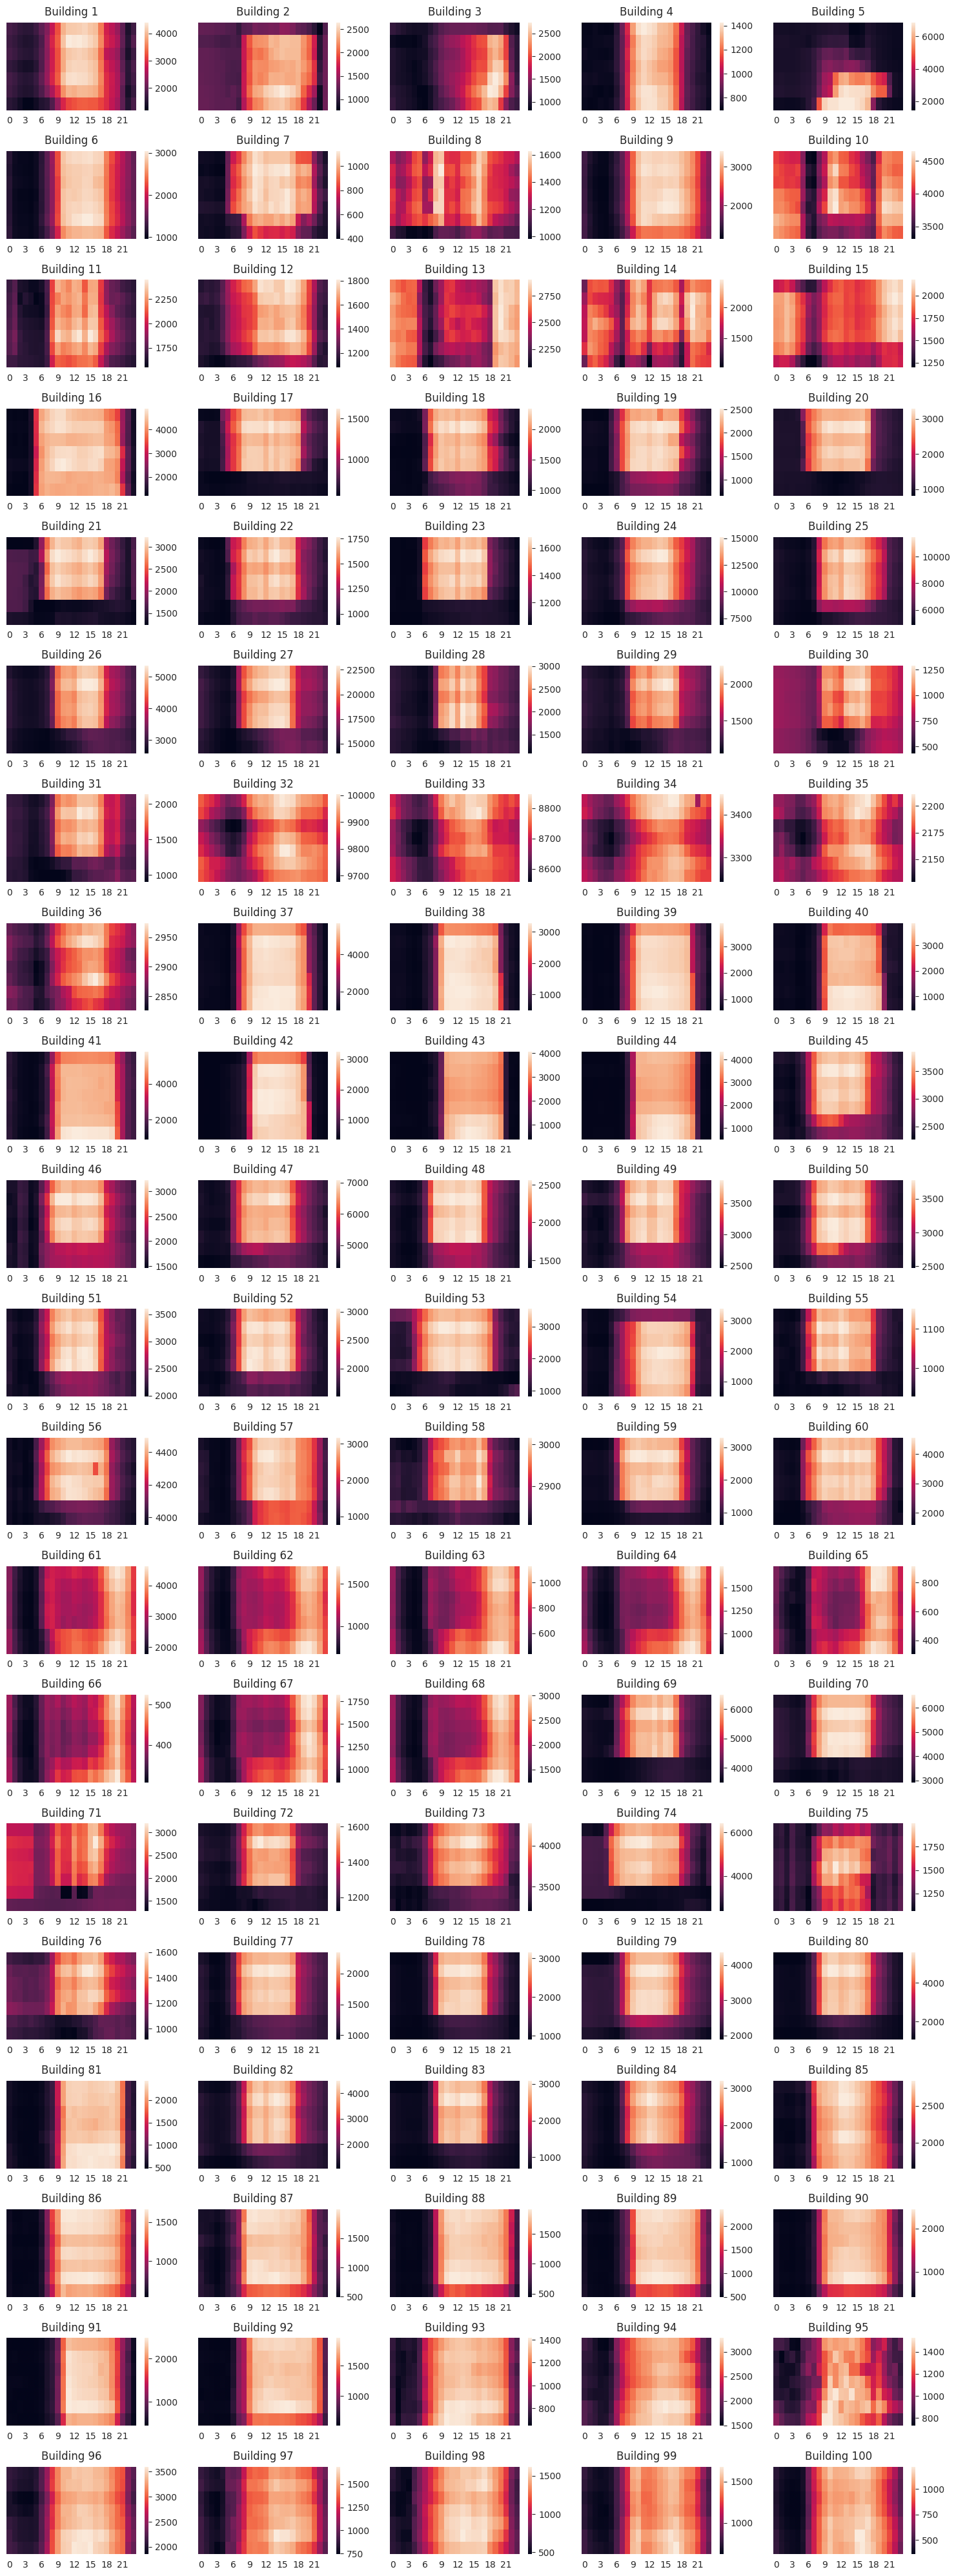

In [95]:
# energy usage of each building ~ weekday, hour
fig = plt.figure(figsize=(15, 40))
for i, num in enumerate(eda_df['num'].unique()):
    df = eda_df[eda_df.num == num]
    df = df.groupby(['weekday', 'hour'])['target'].mean().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(20, 5, i+1)
    sns.heatmap(df)
    plt.title(f'Building {num}', y=1.02)  # 조정된 타이틀 위치
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

plt.tight_layout()  # 서브플롯 간격 조절
plt.show()

<Axes: xlabel='date_time', ylabel='target'>

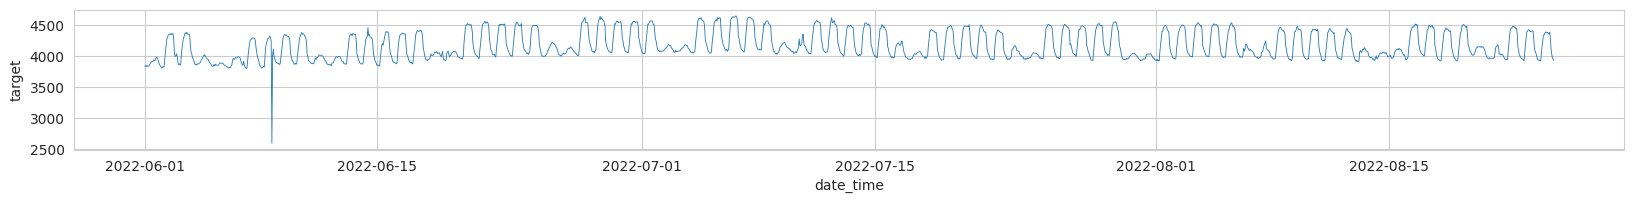

In [96]:
num_56 = eda_df[eda_df.num == 56]

fig = plt.figure(figsize = (20, 4))
plt.subplot(212)
sns.lineplot(data = num_56, x = 'date_time', y = 'target', linewidth = 0.6)

In [97]:
print(num_56.loc[num_56.target < 3000, 'date_time'])

112384   2022-06-08 16:00:00
Name: date_time, dtype: datetime64[ns]


In [98]:
# 56번 건물의 2022-06-08 16:00:00 데이터는
# 이상치인 것으로 판단하고, 모델링 시, 주변값의 평균으로 해당 이상치를 채우기로 결정

<Axes: xlabel='date_time', ylabel='target'>

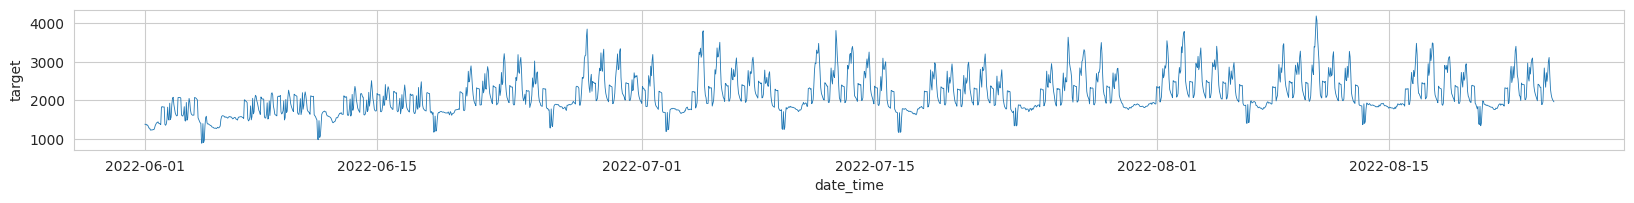

In [99]:
num_71 = eda_df[eda_df.num == 71]

fig = plt.figure(figsize = (20, 4))
plt.subplot(212)
sns.lineplot(data = num_71, x = 'date_time', y = 'target', linewidth = 0.6)

In [100]:
print(num_71.loc[num_71.target < 1200, 'date_time'])

142882   2022-06-04 10:00:00
142883   2022-06-04 11:00:00
142885   2022-06-04 13:00:00
142886   2022-06-04 14:00:00
143050   2022-06-11 10:00:00
143051   2022-06-11 11:00:00
143053   2022-06-11 13:00:00
143054   2022-06-11 14:00:00
143218   2022-06-18 10:00:00
143219   2022-06-18 11:00:00
143554   2022-07-02 10:00:00
143555   2022-07-02 11:00:00
143891   2022-07-16 11:00:00
143893   2022-07-16 13:00:00
143894   2022-07-16 14:00:00
Name: date_time, dtype: datetime64[ns]


In [101]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = eda_df.groupby(['num','weekday'])['target'].median().reset_index().pivot('num','weekday','target').reset_index()
by_hour = eda_df.groupby(['num','hour'])['target'].median().reset_index().pivot('num','hour','target').reset_index().drop('num', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

In [104]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

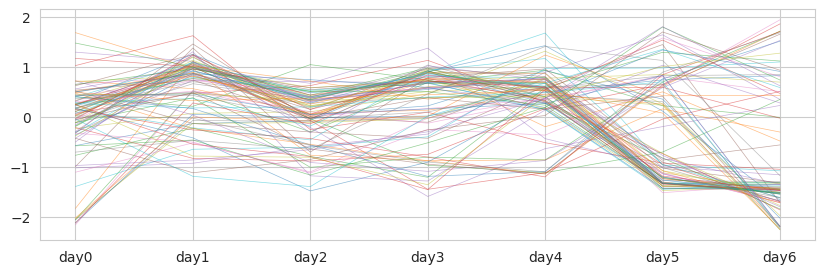

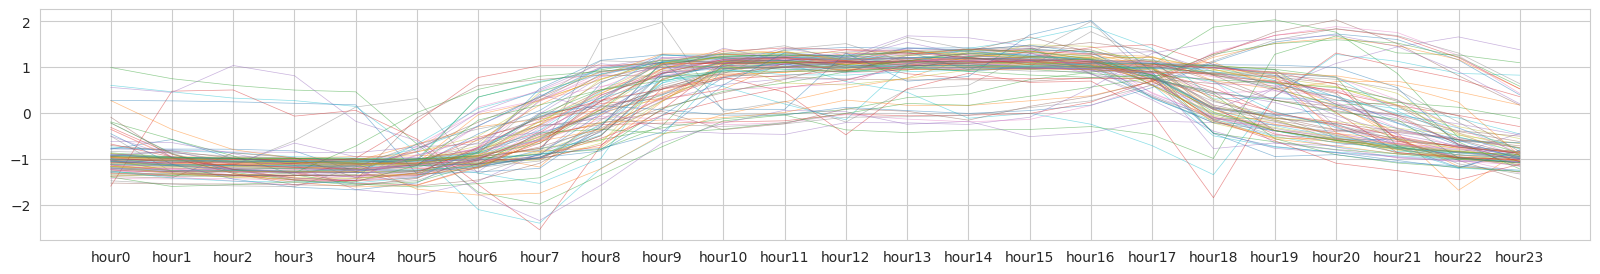

In [105]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

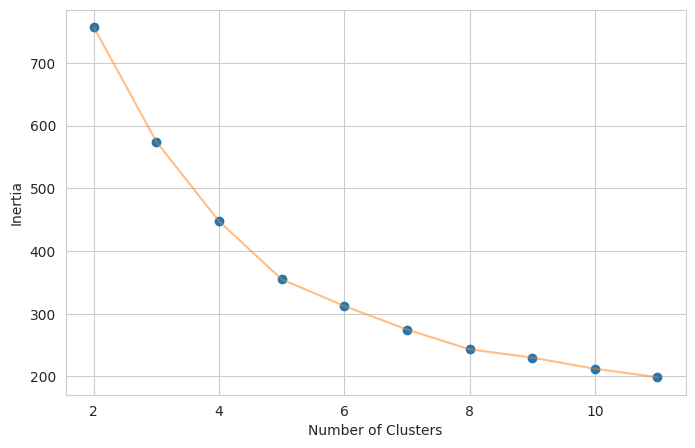

In [107]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)

    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

In [108]:
kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])

In [109]:
df_clust = df.copy()
df_clust['km_cluster'] = km_cluster
df_clust['km_cluster'] = df_clust['km_cluster'].map({0:1, 1:3, 2:2, 3:0})

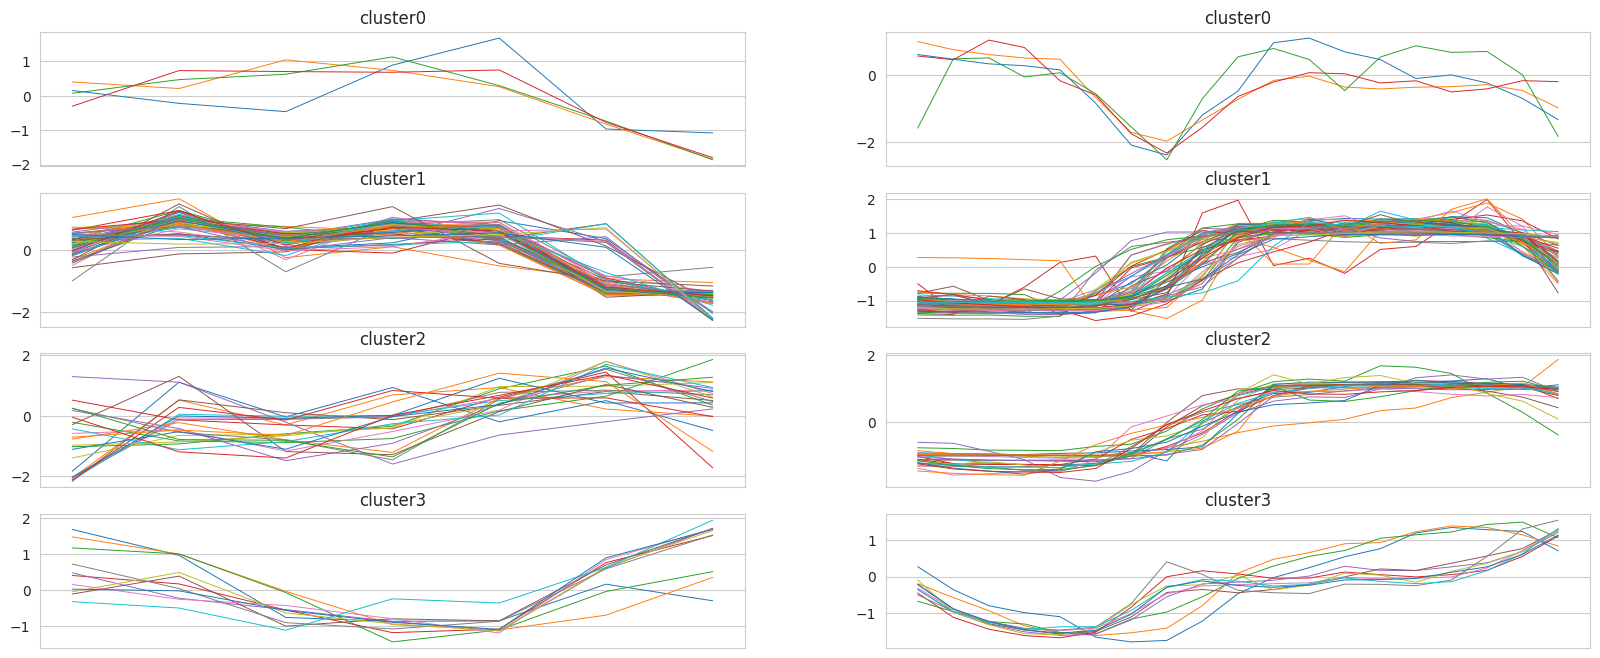

In [110]:
# visualizing result of kmeans clustering
n_c = len(np.unique(df_clust.km_cluster))

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [111]:
eda_df = eda_df.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')

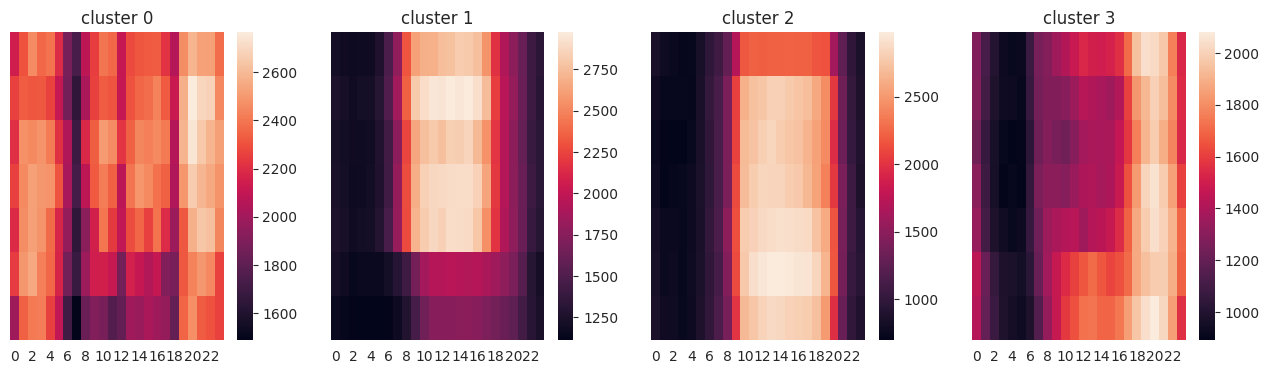

In [112]:
fig = plt.figure(figsize = (20, 4))
for c in range(4):
    temp = eda_df[eda_df.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

```
cluster 0 : 출근 전 시간대에 전력소모가 매우 낮고, 저녁이 될 수록 전력소모가 커짐(산업시설?)
cluster 1 : 평일 주간에 전력소모가 크고, 평일야간이나 주말에는 전력소모가 작은 건물(사무실, 학교)
cluster 2 : 야간과 주간 전력소모 차이는 뚜렷하지만, 평일 주말 관계없이 전력소모가 일정하거나 주말 전력소요가 조금 더 높은 건물(식당, 상점, 카페)
cluster 3 : 평일보다 주말에 전력소모가 크고, 낮보다 밤에 전력소모가 큰 건물(유흥시설, 주점)

```

In [113]:
# dictionary mapping cluster and building
match = df_clust[['num','km_cluster']]
clust_to_num = {0:[],1:[],2:[],3:[]}
for i in range(100):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

In [114]:
# linplot(energy usage of each building ~ cluster, datetime)
for c, col in enumerate(['red','green','orange','blue']):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 2*n_nums))
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums,1, i+1)
        sns.lineplot(data = temp_2, x= 'date_time', y = 'target', linewidth = 0.5, color = col)
        plt.title(f'building {num}')
        plt.subplots_adjust(hspace = 1)
        plt.ylabel('')
        plt.xlabel('')

Output hidden; open in https://colab.research.google.com to view.

```
- cluster 0 : 한 군집으로 분류되긴 했으나, 공통적인 특징이 보이지 않습니다.

- cluster 1 : 평일과 주말이 구분되는 양상을 보입니다. 이 군집에 속한 건물들은 공통적으로 대체공휴일(8.17)에도 전력소요가 낮게 나타납니다. 사무실과 학교 같은 일터 라는 추측에 확신을 가질 수 있습니다.

- cluster 2 : 낮과 밤에 따라서 전력사용량이 증가 감소를 반복하는 경향성이 보입니다.
많은 건물들에서 시간이 지남에 따라 전력소요가 증가하는 양상을 보입니다.(냉방으로 인한 것으로 보입니다.)

- cluster 3 : 공통적으로 더위가 심해질수록 전력사용량이 점진적으로 증가합니다.
```

In [115]:
# cluster 0
df_0 = eda_df[eda_df.km_cluster == 0]
df = df_0.groupby(['num','date'])['기온','강수량','풍속','습도','일조','일사','target'].mean().reset_index()
corrs_0 = []
for num in clust_to_num[0]:
    corr = []
    corr.append(num)
    for feat in ['기온','강수량','풍속','습도','일조','일사']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_0.append(corr)
# cluster 1
df_1 = eda_df[eda_df.km_cluster == 1]
df = df_1.groupby(['num','date'])['기온','강수량','풍속','습도','일조','일사','target'].mean().reset_index()
corrs_1 = []
for num in clust_to_num[1]:
    corr = []
    corr.append(num)
    for feat in ['기온','강수량','풍속','습도','일조','일사']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_1.append(corr)
# cluster 2
df_2 = eda_df[eda_df.km_cluster == 2]
df = df_2.groupby(['num','date'])['기온','강수량','풍속','습도','일조','일사','target'].mean().reset_index()
corrs_2 = []
for num in clust_to_num[2]:
    corr = []
    corr.append(num)
    for feat in ['기온','강수량','풍속','습도','일조','일사']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_2.append(corr)
# cluster 3
df_3 = eda_df[eda_df.km_cluster == 3]
df = df_3.groupby(['num','date'])['기온','강수량','풍속','습도','일조','일사','target'].mean().reset_index()
corrs_3 = []
for num in clust_to_num[3]:
    corr = []
    corr.append(num)
    for feat in ['기온','강수량','풍속','습도','일조','일사']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_3.append(corr)
corrs_total = [corrs_0, corrs_1, corrs_2, corrs_3]

In [116]:
df.isnull().sum()

num         0
date        0
기온          0
강수량       363
풍속          0
습도          0
일조          0
일사          0
target      0
dtype: int64

In [117]:
df['강수량'] = df['강수량'].fillna(0)

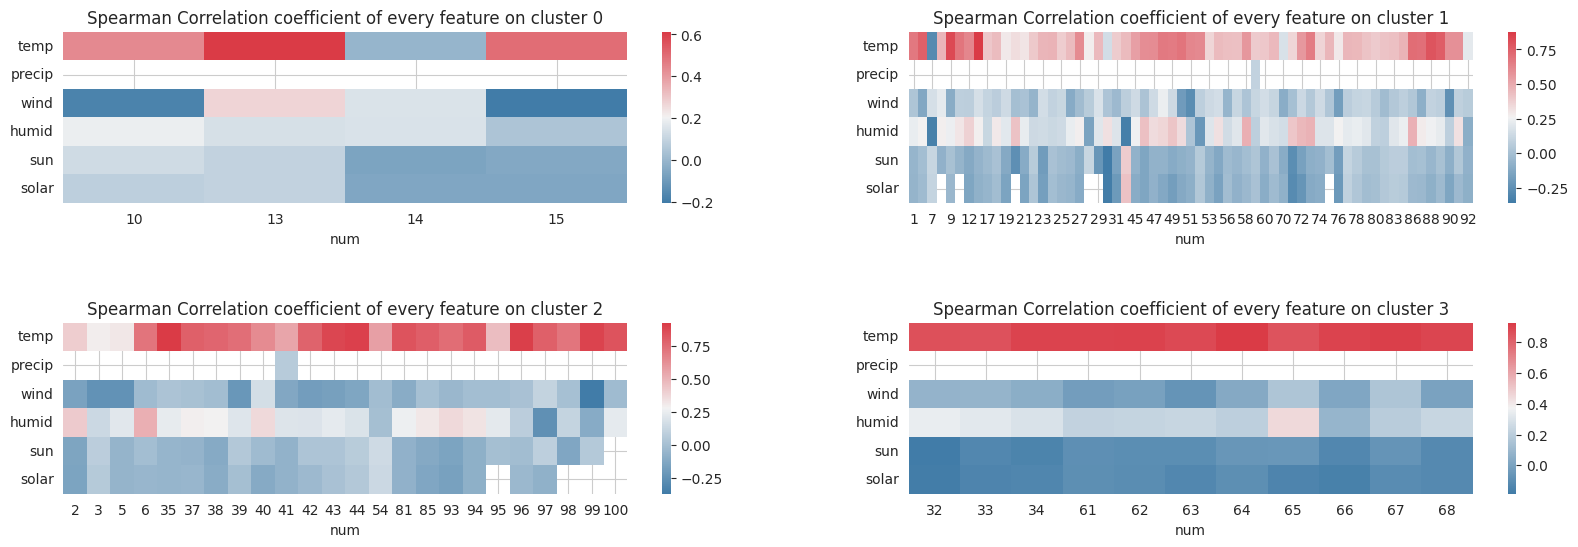

In [118]:
fig = plt.figure(figsize = (20, 6))
for i, corrs in enumerate(corrs_total):
    corr_df = pd.DataFrame(np.array(corrs), columns = ['num','temp','precip','wind','humid','sun','solar'])
    corr_df['num'] = corr_df['num'].astype(int)
    corr_df = corr_df.set_index('num')

    plt.subplot(2,2,i+1)
    sns.heatmap(corr_df.transpose(), cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title(f'Spearman Correlation coefficient of every feature on cluster {i}')

In [119]:
# 날짜별로 일평균 기온과 일평균 전력 사용량의 상관관계 파악
temp_1 = eda_df[eda_df.km_cluster == 0]
nums = np.unique(temp_1.num)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 0')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['target','기온']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='기온', y='target', hue= 'weekend')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(hspace = 0.5)
fig = plt.figure(figsize = (16, 4))
temp_1 = eda_df[eda_df.km_cluster == 1]
nums = np.unique(temp_1.num)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 1')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['target','기온']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='기온', y='target', hue= 'weekend')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(hspace = 0.5)
fig = plt.figure(figsize = (16, 8))
temp_1 = eda_df[eda_df.km_cluster == 2]
nums = np.unique(temp_1.num)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 2')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['target','기온']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='기온', y='target', hue= 'weekend')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(hspace = 0.5)
fig = plt.figure(figsize = (16, 30))
temp_1 = eda_df[eda_df.km_cluster == 3]
nums = np.unique(temp_1.num)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 3')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['target','기온']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='기온', y='target', hue= 'weekend')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(hspace = 0.5)

Output hidden; open in https://colab.research.google.com to view.

In [120]:
# CDH feature추가
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101,1):
    temp = eda_df[eda_df['num'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])
eda_df['CDH'] = cdhs

In [121]:
for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (16, 3*(n_nums//5+1)+1))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        temp_2_tg = temp_2.groupby(['num','date','weekend'])[['target']].mean().reset_index()
        temp_2_cdh = temp_2.groupby(['num','date','weekend'])[['CDH']].mean().reset_index()
        temp_2 = temp_2_tg.merge(temp_2_cdh, on = ['num','date','weekend'], how= 'left')
        plt.subplot(n_nums//5+1,5, i+1)
        sns.scatterplot(data = temp_2, x='CDH', y='target', hue= 'weekend')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')
        plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

Output hidden; open in https://colab.research.google.com to view.

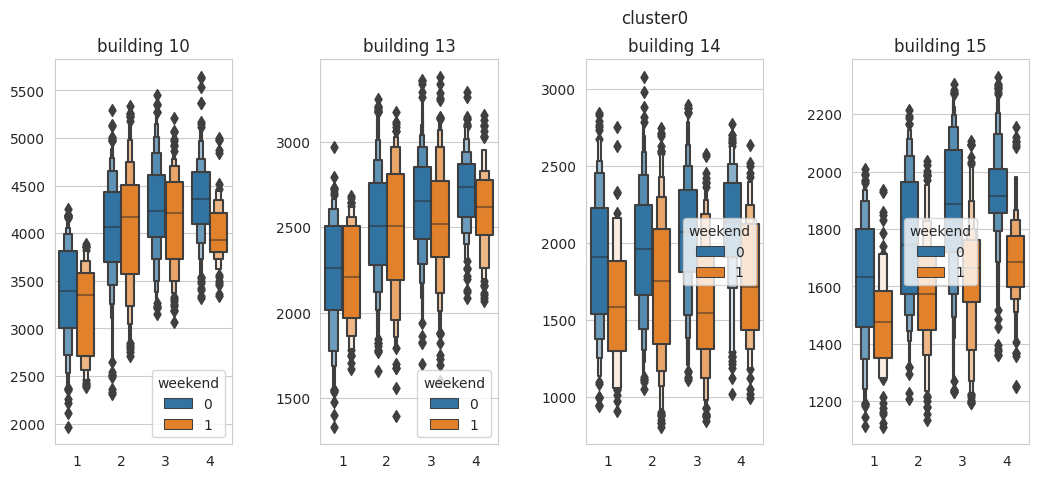

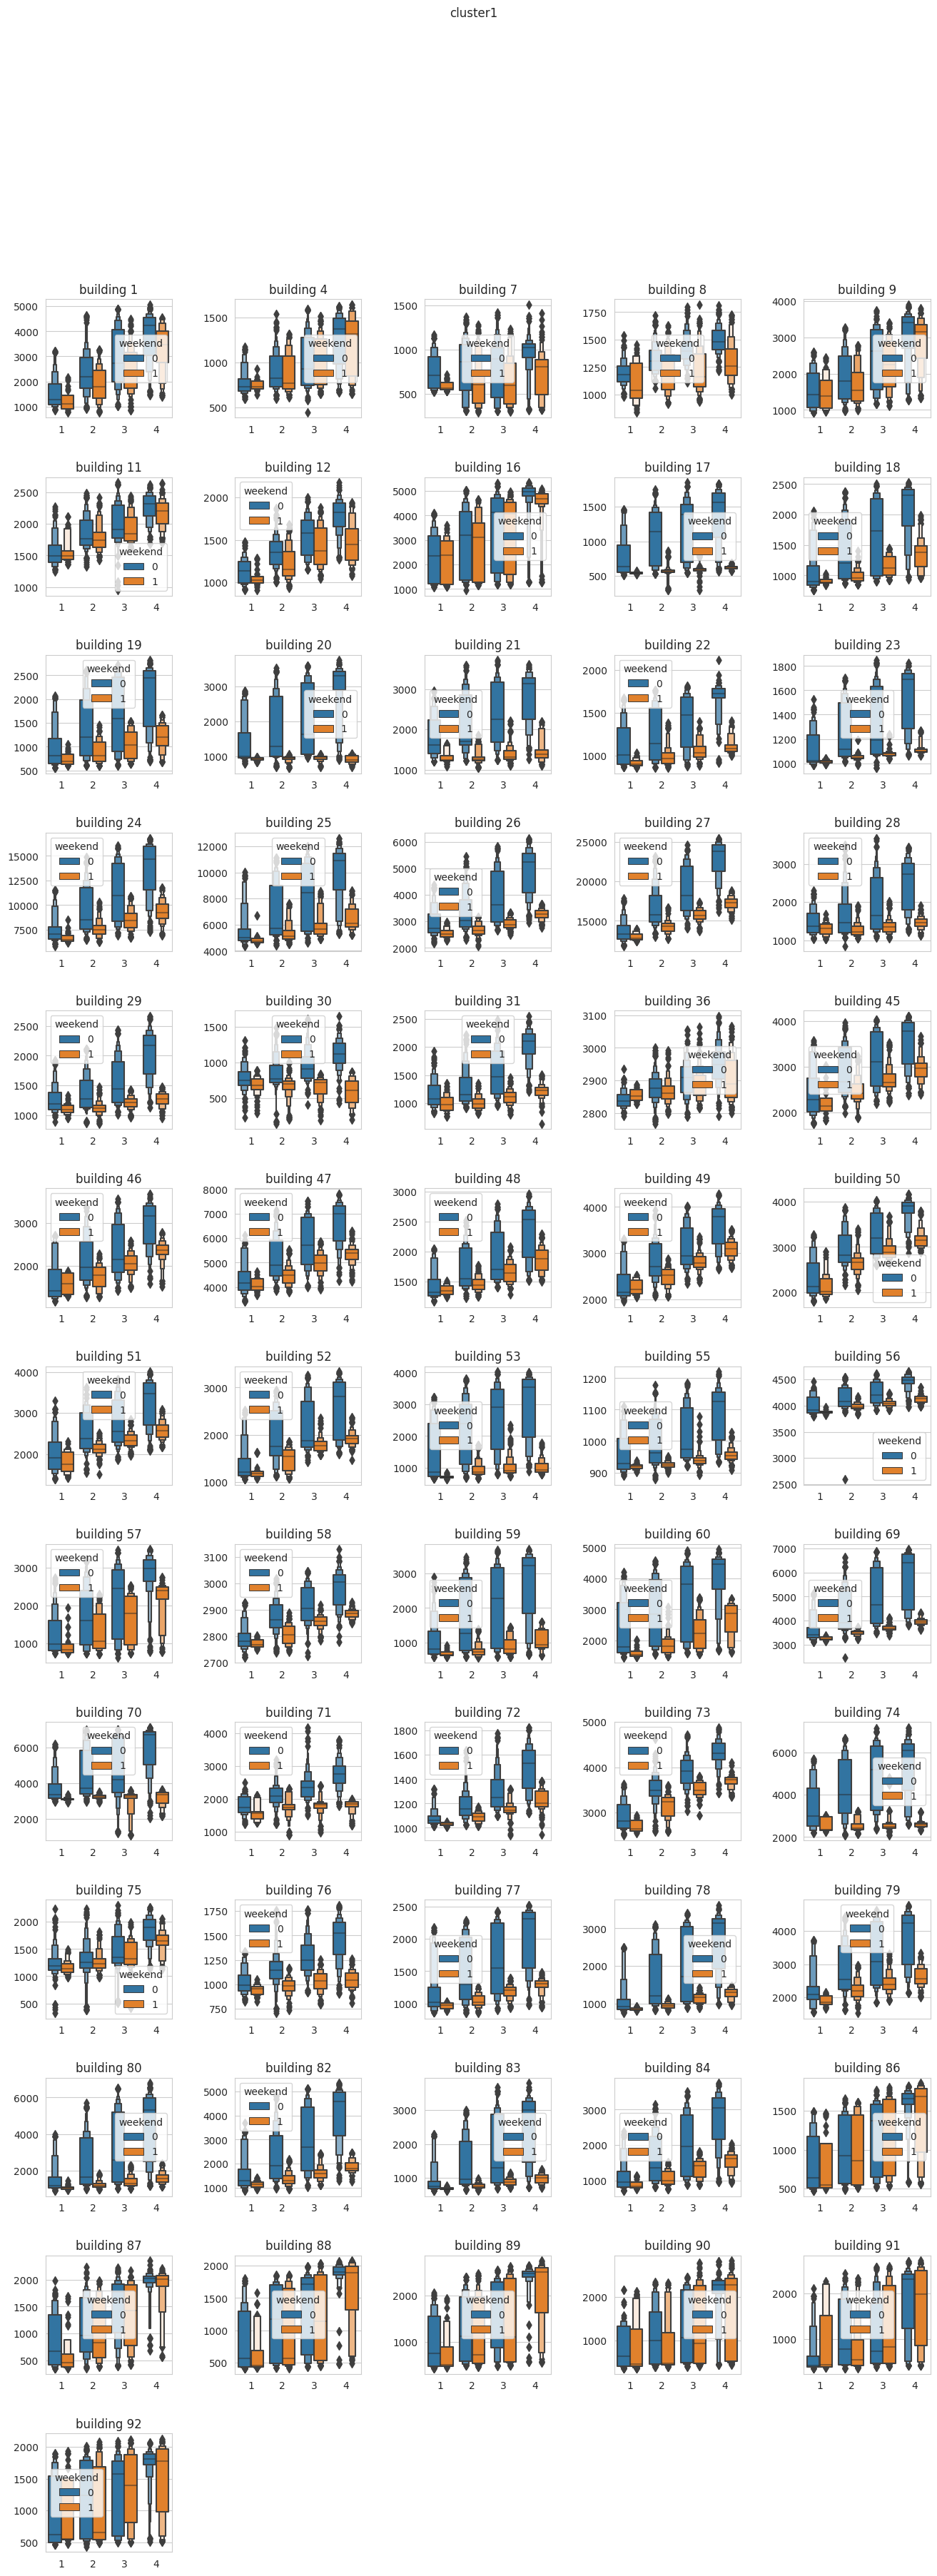

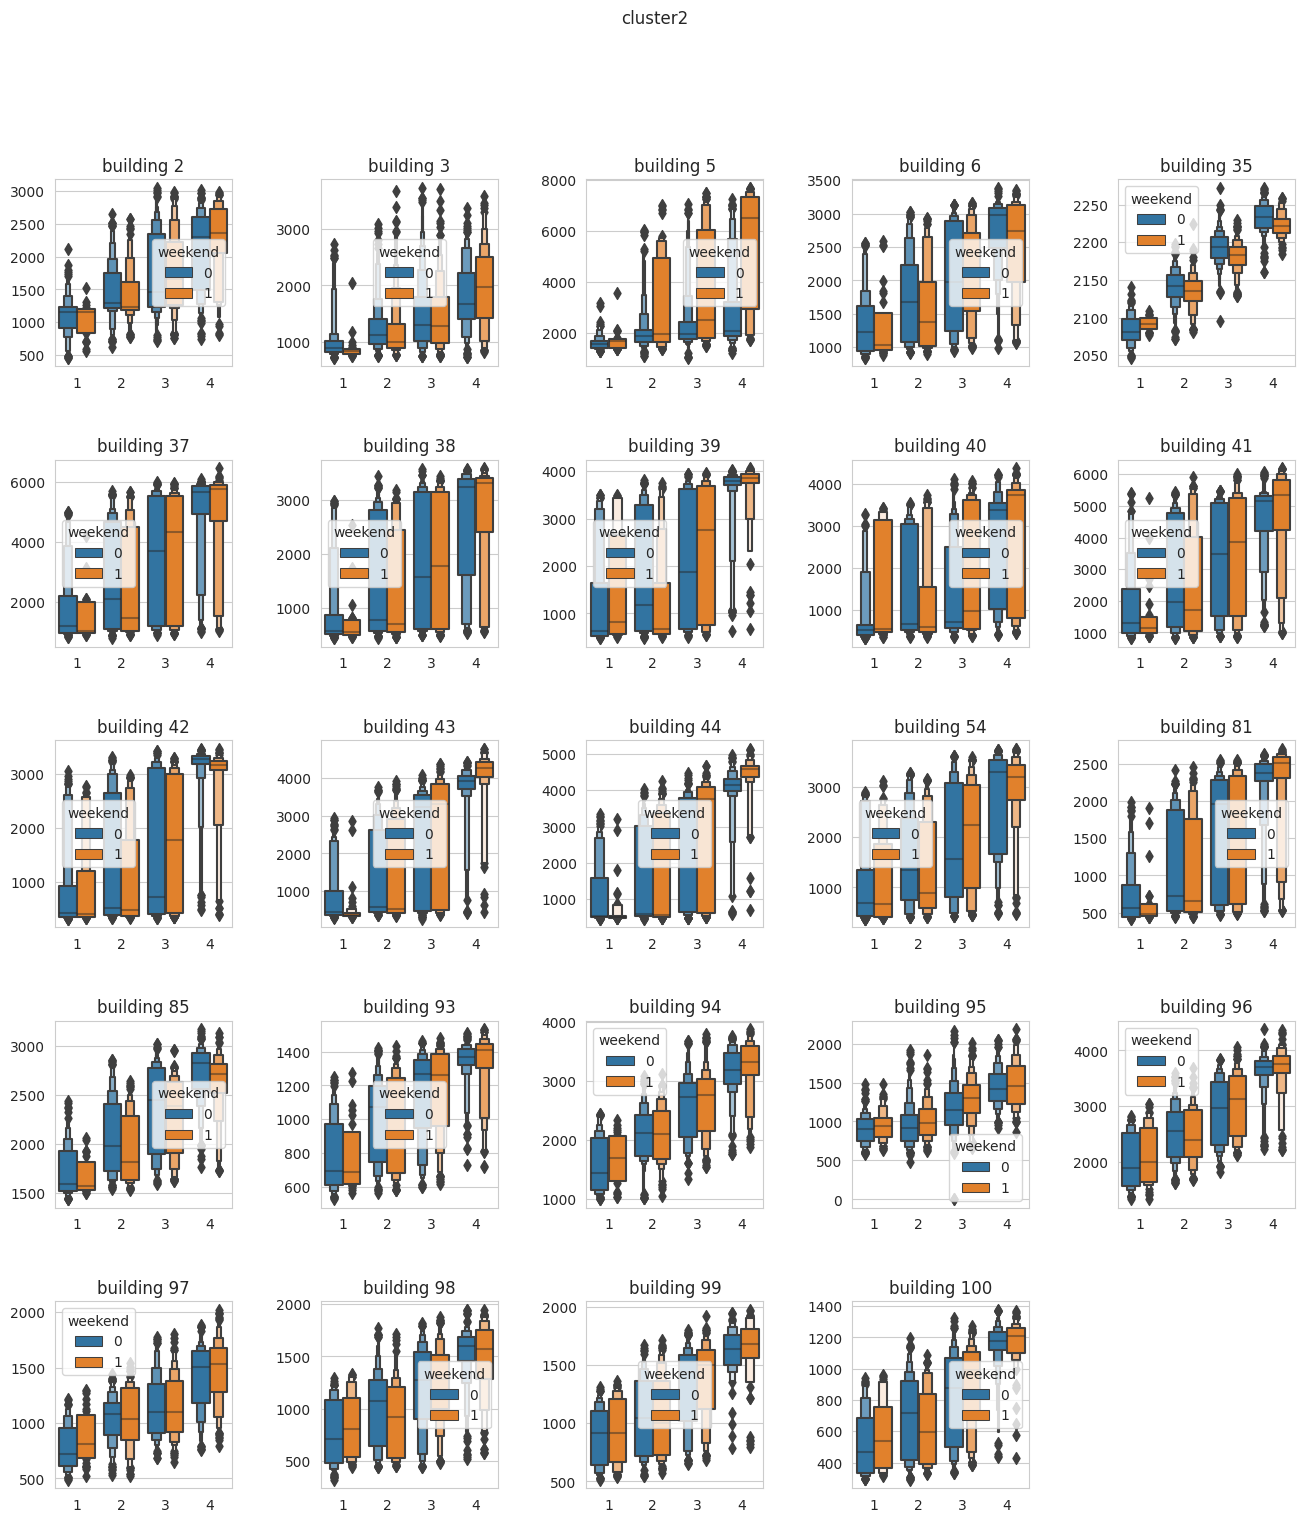

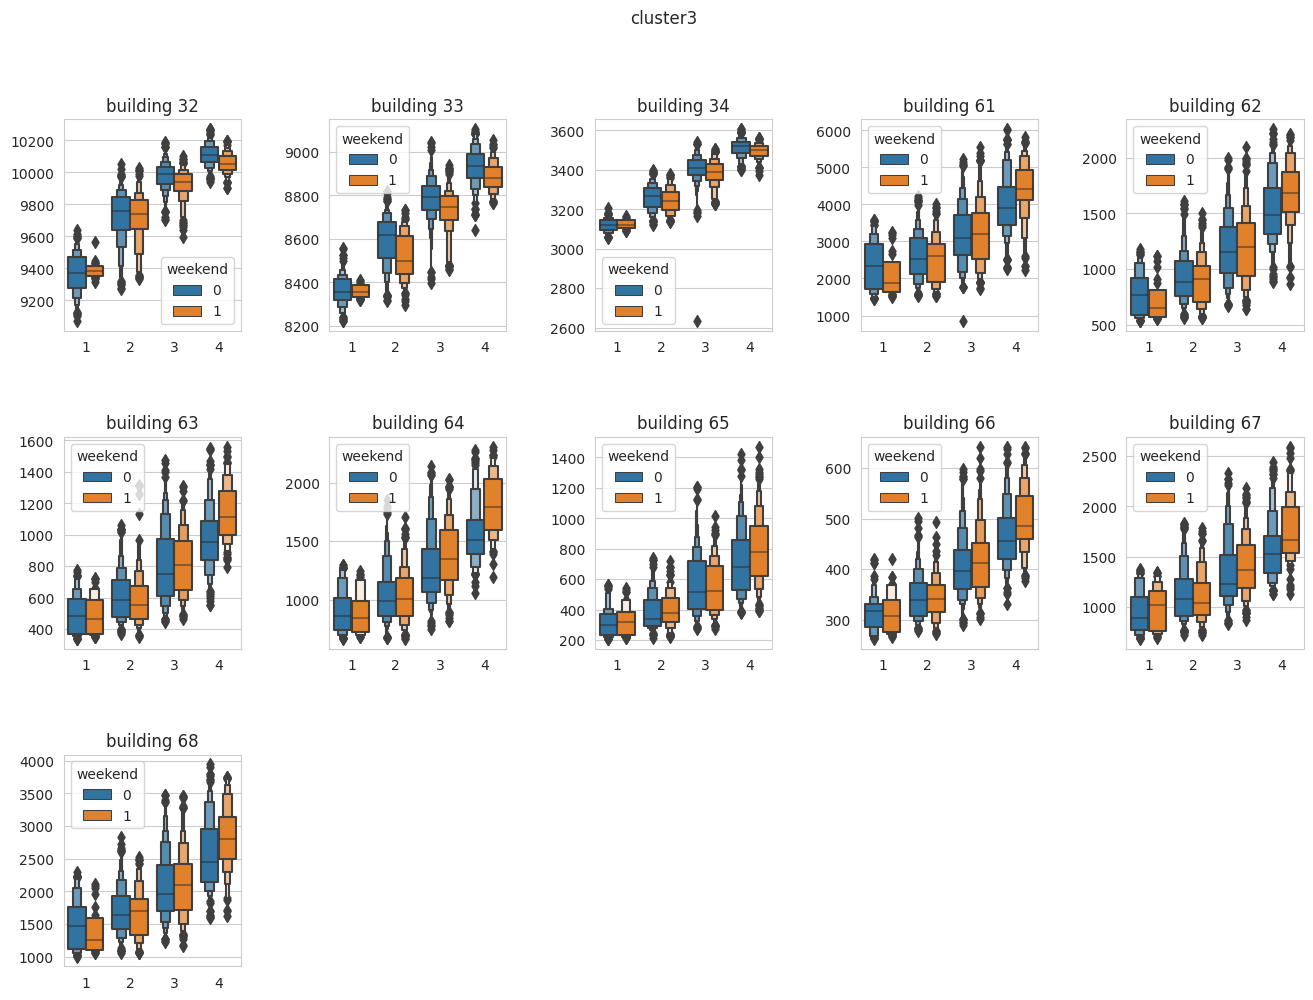

In [122]:
eda_df['THI'] = 9/5*eda_df['기온'] - 0.55*(1-eda_df['습도']/100)*(9/5*eda_df['기온']-26)+32
eda_df['THI_cat'] = pd.cut(eda_df['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])

for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)+2))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums//5+1,5, i+1)
        sns.boxenplot(data = temp_2, x='THI_cat', y='target', hue= 'weekend')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')
        plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

- 56번 건물 이상치 처리

In [123]:
train_df = train.copy()
# outlier processing
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
idx = train_df[(train_df.num == 56)&(train_df.target < 3000)].index[0]
if pd.isna(train_df.iloc[idx, 2]):
    train_df.iloc[idx, 2] = train_df.iloc[idx-1, 2] / 2 + train_df.iloc[idx+1, 2] / 2

- CDH(cooling degree hour, 냉방도일) 함수화
- 기온보다는 `냉방수요` 측면에서 접근 가능
- 냉방 기준온도(26도)

In [124]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

In [125]:
X_train = train_df.copy()

# adding datetime features
X_train['date_time'] = pd.to_datetime(X_train['date_time'])
X_train['hour'] = X_train['date_time'].dt.hour
X_train['month'] = X_train['date_time'].dt.month
X_train['day'] = X_train['date_time'].dt.day
X_train['date'] = X_train['date_time'].dt.date
X_train['weekday'] = X_train['date_time'].dt.weekday

In [126]:
# feature engineering universally applied to every building

## cyclic transformation on hour
X_train['hour_sin'] = np.sin(2 * np.pi * X_train['hour']/23.0)
X_train['hour_cos'] = np.cos(2 * np.pi * X_train['hour']/23.0)
## cyclic transformation on date
X_train['date_sin'] = -np.sin(2 * np.pi * (X_train['month']+X_train['day']/31)/12)
X_train['date_cos'] = -np.cos(2 * np.pi * (X_train['month']+X_train['day']/31)/12)
## cyclic transformation on month
X_train['month_sin'] = -np.sin(2 * np.pi * X_train['month']/12.0)
X_train['month_cos'] = -np.cos(2 * np.pi * X_train['month']/12.0)
## cyclic transformation on weekday
X_train['weekday_sin'] = -np.sin(2 * np.pi * (X_train['weekday']+1)/7.0)
X_train['weekday_cos'] = -np.cos(2 * np.pi * (X_train['weekday']+1)/7.0)

In [127]:
## min temperature
X_train = X_train.merge(X_train.groupby(['num','date'])['기온'].min().reset_index().rename(columns = {'기온':'min_temperature'}), on = ['num','date'], how = 'left')
## THI
X_train['THI'] = 9/5*X_train['기온'] - 0.55*(1-X_train['습도']/100)*(9/5*X_train['기온']-26)+32
## mean THI
X_train = X_train.merge(X_train.groupby(['num','date'])['THI'].mean().reset_index().rename(columns = {'THI':'mean_THI'}), on = ['num','date'], how = 'left')

In [128]:
## CDH
cdhs = np.array([])
for num in range(1,101,1):
    temp = X_train[X_train['num'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])
X_train['CDH'] = cdhs
## mean CDH
X_train = X_train.merge(X_train.groupby(['num','date'])['CDH'].mean().reset_index().rename(columns = {'CDH':'mean_CDH'}), on = ['num','date'], how = 'left')

In [129]:
# droping unnecessry columns
# X_train.drop(['solar_flag', 'nelec_cool_flag'], axis=1, inplace=True)

# split dataframe to separately modeling for each buildings
X_trains = [X_train[X_train.num == num] for num in range(1,101,1)]

In [130]:
## cluster 1
for num in clust_to_num[1]:
    temp_df = X_trains[num-1]
    temp_df = temp_df[~temp_df['date'].map(str).isin(['2020-08-17'])]
    X_trains[num-1] = temp_df
for num in clust_to_num[1]:
    temp_df = X_trains[num-1]
    temp_df['aug_day'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['month']==8)&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
    X_trains[num-1] = temp_df
for num in clust_to_num[1]:
    temp_df = X_trains[num-1]
    temp_df['weekend'] = ((temp_df['weekday'].isin([5,6]))).astype(int)
    X_trains[num-1] = temp_df

In [131]:
## cluster 2
for num in clust_to_num[2]:
    temp_df = X_trains[num-1]
    temp_df['aug_day'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['month']==8)).astype(int)
    X_trains[num-1] = temp_df

In [132]:
## cluster 3
for num in clust_to_num[3]:
    temp_df = X_trains[num-1]
    temp_df['aug_night'] = ((temp_df['hour'].isin([18,19,20,21,22]))&(temp_df['month']==8)).astype(int)
    X_trains[num-1] = temp_df

In [133]:
# weather relevant feature for each building
for num in range(1,101,1):
    temp_df = X_trains[num-1]
    temp_df['THI_cat'] = pd.cut(temp_df['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
    X_trains[num-1] = temp_df

In [ ]:
# target data
y_trains = [df['target'].values for df in X_trains]
X_trains = [df.drop('target', axis = 1) for df in X_trains]
y_trains_log = [np.log(df) for df in y_trains]

In [138]:
X_trains_ohe = X_trains.copy()

## one hot encoding for weekday, hour, THI
for i, X_train in enumerate(X_trains_ohe):
    X_train = pd.concat([X_train, pd.get_dummies(X_train['weekday'], prefix ='weekday')], axis=1)
    X_train = pd.concat([X_train, pd.get_dummies(X_train['hour'], prefix ='hour')], axis=1)
    X_train = pd.concat([X_train, pd.get_dummies(X_train['THI_cat'], prefix ='THI')], axis=1)
    X_trains_ohe[i] = X_train

In [139]:
# drop unnecessary columns
X_trains = [df.drop(['num', 'date_time', 'day', 'date','기온','강수량','일조','일사','num_date_time'], axis=1).reset_index().drop('index', axis=1) for df in X_trains]
X_trains_ohe = [df.drop(['num', 'date_time', 'day', 'date', 'weekday', 'hour', 'month', 'THI_cat','기온','강수량','일조','일사','num_date_time'], axis=1).reset_index().drop('index', axis=1) for df in X_trains_ohe]

- 테스트데이터 적용

In [136]:
# data preprocessing function for testset
def test_preprocess(test):
    X_train = test.copy()
    X_train = X_train.interpolate()

    X_train['date_time'] = pd.to_datetime(X_train['date_time'])
    X_train['hour'] = X_train['date_time'].dt.hour
    X_train['month'] = X_train['date_time'].dt.month
    X_train['day'] = X_train['date_time'].dt.day
    X_train['date'] = X_train['date_time'].dt.date
    X_train['weekday'] = X_train['date_time'].dt.weekday

    # feature engineering universally applied to every building

    ## cyclic transformation on hour
    X_train['hour_sin'] = np.sin(2 * np.pi * X_train['hour']/23.0)
    X_train['hour_cos'] = np.cos(2 * np.pi * X_train['hour']/23.0)
    ## cyclic transformation on date
    X_train['date_sin'] = -np.sin(2 * np.pi * (X_train['month']+X_train['day']/31)/12.0)
    X_train['date_cos'] = -np.cos(2 * np.pi * (X_train['month']+X_train['day']/31)/12.0)
    ## cyclic transformation on month
    X_train['month_sin'] = -np.sin(2 * np.pi * X_train['month']/12.0)
    X_train['month_cos'] = -np.cos(2 * np.pi * X_train['month']/12.0)
    ## cyclic transformation on weekday
    X_train['weekday_sin'] = -np.sin(2 * np.pi * (X_train['weekday']+1)/7.0)
    X_train['weekday_cos'] = -np.cos(2 * np.pi * (X_train['weekday']+1)/7.0)

    ## daily minimum temperature
    X_train = X_train.merge(X_train.groupby(['num','date'])['기온'].min().reset_index().rename(columns = {'기온':'min_temperature'}), on = ['num','date'], how = 'left')
    ## THI
    X_train['THI'] = 9/5*X_train['기온'] - 0.55*(1-X_train['습도']/100)*(9/5*X_train['기온']-26)+32
    ## mean_THI
    X_train = X_train.merge(X_train.groupby(['num','date'])['THI'].mean().reset_index().rename(columns = {'THI':'mean_THI'}), on = ['num','date'], how = 'left')
    ## CDH
    cdhs = np.array([])
    for num in range(1,101,1):
        temp = X_train[X_train['num'] == num]
        cdh = CDH(temp['기온'].values)
        cdhs = np.concatenate([cdhs, cdh])
    X_train['CDH'] = cdhs
    ## mean_CDH
    X_train = X_train.merge(X_train.groupby(['num','date'])['CDH'].mean().reset_index().rename(columns = {'CDH':'mean_CDH'}), on = ['num','date'], how = 'left')

    X_trains = [X_train[X_train.num == num] for num in range(1,101,1)]

    # applying seperate feature engineering for each clusters
    ## cluster 1
    for num in clust_to_num[1]:
        temp_df = X_trains[num-1]
        temp_df = temp_df[~temp_df['date'].map(str).isin(['2020-08-17'])]
        X_trains[num-1] = temp_df
    for num in clust_to_num[1]:
        temp_df = X_trains[num-1]
        temp_df['aug_day'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['month']==8)&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        X_trains[num-1] = temp_df
    for num in clust_to_num[1]:
        temp_df = X_trains[num-1]
        temp_df['weekend'] = ((temp_df['weekday'].isin([5,6]))).astype(int)
        X_trains[num-1] = temp_df

    ## cluster 2
    for num in clust_to_num[2]:
        temp_df = X_trains[num-1]
        temp_df['aug_day'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['month']==8)).astype(int)
        X_trains[num-1] = temp_df

    ## cluster 3
    for num in clust_to_num[3]:
        temp_df = X_trains[num-1]
        temp_df['aug_night'] = ((temp_df['hour'].isin([18,19,20,21,22]))&(temp_df['month']==8)).astype(int)
        X_trains[num-1] = temp_df

    # weather relevant feature for each building
    for num in range(1,101,1):
        temp_df = X_trains[num-1]
        temp_df['THI_cat'] = pd.cut(temp_df['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
        X_trains[num-1] = temp_df

    X_trains_ohe = X_trains.copy()

    ## one hot encoding for weekday, hour, THI
    for i, X_train in enumerate(X_trains_ohe):
        X_train = pd.concat([X_train, pd.get_dummies(X_train['weekday'], prefix ='weekday')], axis=1)
        X_train = pd.concat([X_train, pd.get_dummies(X_train['hour'], prefix ='hour')], axis=1)
        X_train = pd.concat([X_train, pd.get_dummies(X_train['THI_cat'], prefix ='THI')], axis=1)
        X_trains_ohe[i] = X_train

    # drop unnecessary columns
    X_trains = [df.drop(['num', 'date_time', 'day', 'date','기온','강수량','num_date_time'], axis=1).reset_index().drop('index', axis=1) for df in X_trains]
    X_trains_ohe = [df.drop(['num', 'date_time', 'day', 'date', 'weekday', 'hour', 'month', 'THI_cat','기온','강수량','num_date_time'], axis=1).reset_index().drop('index', axis=1) for df in X_trains_ohe]

    return X_trains, X_trains_ohe

# drop만 할것!

In [ ]:
X_tests, X_tests_ohe = test_preprocess(test)

In [ ]:
type(X_trains_ohe), type(y_trains_log)

(list, list)

- 모델링

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.6 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor

In [ ]:
tree_models = [CatBoostRegressor(subsample=1.0, random_state=SEED, verbose=False) for i in range(100)]

In [ ]:
tree_models = [CatBoostRegressor(bootstrap_type='Bayesian', random_state=SEED, verbose=False) for i in range(100)]
fi = []
for i, (X_tr, y_tr, model) in enumerate(zip(X_trains_ohe, y_trains_log, tree_models)):
    model.fit(X_tr, y_tr)
    imp = model.feature_importances_
    nm = model.feature_names_
    fi_df = pd.DataFrame({'feature':nm, 'importance':imp}).sort_values('importance', ascending = False)
    fi.append(fi_df)

CatBoostError: ignored

In [ ]:
# Top 10 visualization
clust_0 = clust_to_num[0]
clust_1 = clust_to_num[1]
clust_2 = clust_to_num[2]
clust_3 = clust_to_num[3]

# clust_0
fig = plt.figure(figsize = (16, 1+3*7))
plt.suptitle('cluster 0')
for k, num in enumerate(clust_0):
    fi_df = fi[num-1]
    plt.subplot(7,2,k+1)
    sns.barplot(data = fi_df.head(10), orient = 'h', x = 'importance', y ='feature', palette = 'Reds')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.title(f'building {num}')
    plt.subplots_adjust(wspace = 0.3)

In [ ]:
# clust_1
fig = plt.figure(figsize = (16, 1+3*2))
plt.suptitle('cluster 1')
for k, num in enumerate(clust_1):
    fi_df = fi[num-1]
    plt.subplot(2,2,k+1)
    sns.barplot(data = fi_df.head(10), orient = 'h', x = 'importance', y ='feature', palette = 'Reds')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.title(f'building {num}')
    plt.subplots_adjust(wspace = 0.3)

In [ ]:
# clust_2
fig = plt.figure(figsize = (16, 1+3*4))
plt.suptitle('cluster 2')
for k, num in enumerate(clust_2):
    fi_df = fi[num-1]
    plt.subplot(3,2,k+1)
    sns.barplot(data = fi_df.head(10), orient = 'h', x = 'importance', y ='feature', palette = 'Reds')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.title(f'building {num}')
    plt.subplots_adjust(wspace = 0.3)

In [ ]:
# clust_3
fig = plt.figure(figsize = (16, 1+3*18))
plt.suptitle('cluster 3')
for k, num in enumerate(clust_3):
    fi_df = fi[num-1]
    plt.subplot(19,2,k+1)
    sns.barplot(data = fi_df.head(10), orient = 'h', x = 'importance', y ='feature', palette = 'Reds')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.title(f'building {num}')
    plt.subplots_adjust(wspace = 0.3)

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

In [ ]:
cv = KFold(n_splits=5,shuffle=True, random_state=SEED)

# 모델 검토